In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import random

import cv2
import glob
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
# function to read images from path. results are numpy arrays
def read_images(path):
    return [cv2.imread(file) for file in glob.glob(path)]

In [3]:
# function to read images from path. results are images
def read_images2(path):
    return [Image.open(file) for file in glob.glob(path)]

In [4]:
path_y = './brain-mri-images-for-brain-tumor-detection/yes/*'
path_n = './brain-mri-images-for-brain-tumor-detection/no/*'

images_y = read_images2(path_y)
images_n = read_images2(path_n)

In [5]:
def show_images(img1, img2):
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title('Brain with tumor')
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title('Brain without tumor')

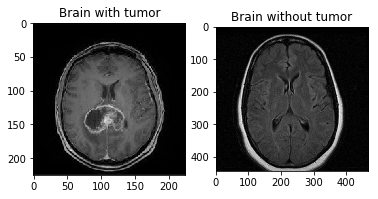

In [6]:
show_images(images_y[0], images_n[0])

In [7]:
# squaring images function:
# desired_size: a square which side is the max between original base and height
# creates a black image with desired size
# pastes the original image in the 'center' of the new image
def square_image(list_of_images):
    res = []
    for img in list_of_images:
        desired_size = (max(img.size), max(img.size))
        position = int(max(img.size)/2) - int(min(img.size)/2) 
        sq_img = Image.new("RGB", desired_size, color='black')
        if img.size[0] < img.size[1]:
            sq_img.paste(img, (0, position))
        else:
            sq_img.paste(img, (position, 0))
        res.append(sq_img)
    return res

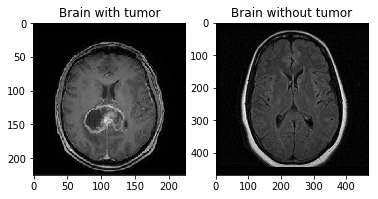

In [8]:
images_y_sq = square_image(images_y)
images_n_sq = square_image(images_n)
show_images(images_y_sq[0], images_n_sq[0])

In [9]:
# now we want to reshape all the images to 64x64
def resize_images(list_of_images, size=128):
    return [img.resize((size,size)) for img in list_of_images]

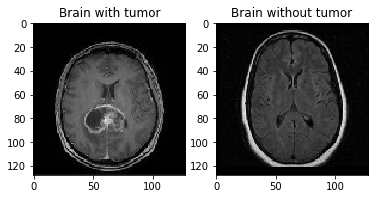

In [10]:
images_y_sq_rs = resize_images(images_y_sq)
images_n_sq_rs = resize_images(images_n_sq)
show_images(images_y_sq_rs[0], images_n_sq_rs[0])

In [11]:
# now we start to use open cv library, that works with numpy arrays instead of images
def image_to_nparray(list_of_images):
    return [np.array(img) for img in list_of_images]

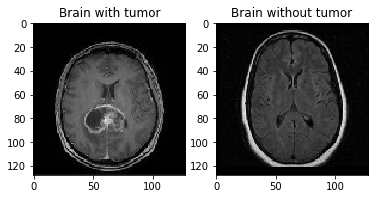

In [12]:
images_y_sq_rs_np = image_to_nparray(images_y_sq_rs)
images_n_sq_rs_np = image_to_nparray(images_n_sq_rs)
show_images(images_y_sq_rs_np[0], images_n_sq_rs_np[0])

In [13]:
# function to get gray scale images
def img_to_gray_scale(list_of_images):
    return [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in list_of_images]

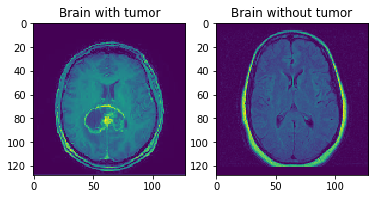

In [14]:
images_y_sq_rs_np_gs = img_to_gray_scale(images_y_sq_rs_np)
images_n_sq_rs_np_gs = img_to_gray_scale(images_n_sq_rs_np)
show_images(images_y_sq_rs_np_gs[0], images_n_sq_rs_np_gs[0])

In [15]:
def median_filter(list_of_images):
    return [cv2.medianBlur(img,3) for img in list_of_images]

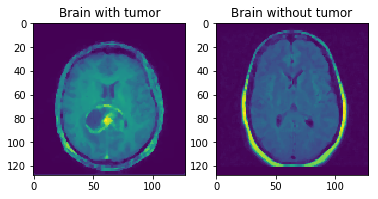

In [16]:
images_y_sq_rs_np_gs_mf = median_filter(images_y_sq_rs_np_gs)
images_n_sq_rs_np_gs_mf = median_filter(images_n_sq_rs_np_gs)
show_images(images_y_sq_rs_np_gs_mf[0], images_n_sq_rs_np_gs_mf[0])

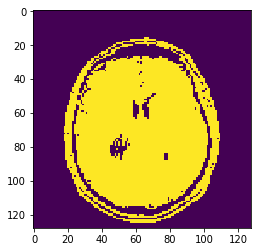

In [17]:
# prueba de segmentación
ret, thresh = cv2.threshold(images_y_sq_rs_np_gs[0],0,255,cv2.THRESH_OTSU)
plt.imshow(thresh)

In [18]:
ret, markers = cv2.connectedComponents(thresh)
print(thresh)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [19]:
# function to transform list of images to b&w
# I get the element 1 because it returs a tuple (threshold, image)
# meaning of the threshold: 0 is black, 255 is white, so I set that the pixels which are below 127
# turn black, and the ones that are above 127 turn white
def images_to_bw(list_of_images):
    return [cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)[1] for img in list_of_images]

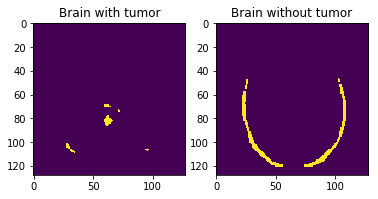

In [20]:
images_y_sq_rs_np_gs_mf_bw = images_to_bw(images_y_sq_rs_np_gs_mf)
images_n_sq_rs_np_gs_mf_bw = images_to_bw(images_n_sq_rs_np_gs_mf)
show_images(images_y_sq_rs_np_gs_mf_bw[0], images_n_sq_rs_np_gs_mf_bw[0])

In [21]:
# function to convert the images (np arrays 256x256) in 1d arrays
# and then put them all together in a pandas dataframe
def list_np_to_pd(list_of_images):
    return pd.DataFrame([img.flatten() for img in list_of_images])

In [22]:
# execution of the function
images_dataframe_y = list_np_to_pd(images_y_sq_rs_np_gs_mf_bw)
images_dataframe_n = list_np_to_pd(images_n_sq_rs_np_gs_mf_bw)

In [23]:
# prueba con las imágenes en b&w
#images_dataframe_y = list_np_to_pd(images_y_sq_rs_np_gs_mf_bw)
#images_dataframe_n = list_np_to_pd(images_n_sq_rs_np_gs_mf_bw)

In [24]:
images_dataframe_y.shape

(155, 16384)

In [25]:
# display(images_dataframe_y.head())
# display(images_dataframe_n.head())

In [26]:
# function to add a column with the ground truth
# the idea is to put a 1 if there is a tumor and 0 if there is not one
def add_ground_truth(dataframe, groundtruth):
    dataframe['diagnose'] = groundtruth
    return dataframe

In [27]:
# show random image
def show_random_images(list1, list2):
    plt.subplot(1,2,1)
    plt.imshow(random.choice(list1))
    plt.title('Brain with tumor')
    plt.subplot(1,2,2)
    plt.imshow(random.choice(list2))
    plt.title('Brain without tumor')

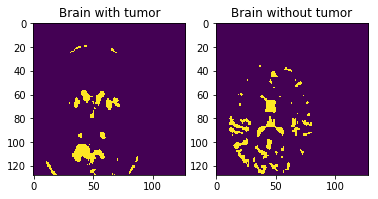

In [28]:
show_random_images(images_y_sq_rs_np_gs_mf_bw, images_n_sq_rs_np_gs_mf_bw)

In [29]:
# adding groundtruth
# final_df_y = add_ground_truth(images_dataframe_y, 1)
# final_df_n = add_ground_truth(images_dataframe_n, 0)

In [30]:
# concatenate both dataframes
# final_df = pd.concat((final_df_y, final_df_n))
# final_df.shape

In [31]:
# X = final_df.drop(columns='diagnose')
# y = final_df['diagnose']

In [32]:
# print("Shapes X={} y={}".format(X.shape,y.shape))

In [33]:
# input image dimensions
img_rows, img_cols = 128, 128

df_y = images_dataframe_y.T
df_n = images_dataframe_n.T
print(images_dataframe_y.shape)
print(df_y.shape)

num_y = df_y.values.shape[1]
num_n = df_n.values.shape[1]
print("y:{} n:{}".format(num_y, num_n))

yes = df_y.values.reshape((img_rows, img_cols, num_y))
no = df_n.values.reshape((img_rows, img_cols, num_n))
X = np.concatenate((yes,no), axis=2).swapaxes(2,0)
y = np.concatenate((np.ones(num_y),np.zeros(num_n)))
print("Shapes X={} y={}".format(X.shape,y.shape))

(155, 16384)
(16384, 155)
y:155 n:98
Shapes X=(253, 128, 128) y=(253,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [35]:
# Prepare data to feed the NN
num_classes = 2


# Ask keras which format to use depending on used backend and arrange data as expected
if K.image_data_format() == 'channels_first':
    X_train = x_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = x_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Incoming data is in uint8. Cast the input data images to be floats in range [0.0-1.0]  
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (227, 128, 128, 1)
227 train samples
26 test samples


In [36]:
## This is the neural network proposed architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [37]:
# Fit the NN
batch_size = 20
epochs = 10

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 227 samples, validate on 26 samples
Epoch 1/10
227/227 [==============================] - 17s 74ms/step - loss: 0.6351 - acc: 0.6828 - val_loss: 0.4660 - val_acc: 0.8077
Epoch 2/10
227/227 [==============================] - 15s 67ms/step - loss: 0.3687 - acc: 0.8634 - val_loss: 0.4764 - val_acc: 0.6538
Epoch 3/10
227/227 [==============================] - 15s 67ms/step - loss: 0.2918 - acc: 0.9207 - val_loss: 0.3227 - val_acc: 0.8462
Epoch 4/10
227/227 [==============================] - 15s 66ms/step - loss: 0.1479 - acc: 0.9559 - val_loss: 0.3725 - val_acc: 0.7692
Epoch 5/10
227/227 [==============================] - 15s 67ms/step - loss: 0.0874 - acc: 0.9736 - val_loss: 0.4275 - val_acc: 0.8462
Epoch 6/10
227/227 [==============================] - 15s 67ms/step - loss: 0.0582 - acc: 0.9824 - val_loss: 0.5266 - val_acc: 0.7692
Epoch 7/10
227/227 [==============================] - 15s 67ms/step - loss: 0.0350 - acc: 0.9956 - val_

In [38]:
# Evaluate the model with test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5292196273803711
Test accuracy: 0.7692307829856873


Probs -> 1:0.02834 0:0.97166


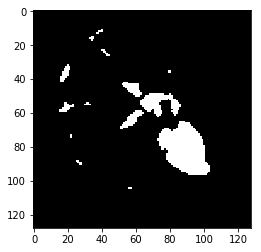

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
img = X_test[15]
pred = model.predict(np.expand_dims(img,axis=0))[0]
print("Probs -> 1:{0:.5f} 0:{1:.5f}".format(pred[0],pred[1]))
plt.imshow(Image.fromarray(img.squeeze()*255),'gray')